**Q: What accuracy would a random classifier (which assigns labels randomly) achieve on this task (approximately)? **

A: The accuracy will approximate 20% because our dataset only has true labels values witnin 0,1,2,3,and 4. So the true label of each example has a 20% chance to be chosen by a random classifier, which makes our overall predication accuracy approximately to be 20%.

**What accuracy would a majority-vote classifier achieve on this task (approximately)?**

A: With a majority-vote classifier, the accuracy will also approximate to 20%. Since each label between 0-4 exists the same amount in the dataset, they share the same majority. Thus, our classifier will randomly choose a label an apply it to all examples, which makes it the same as a random classifier.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import autograd
import torch.nn.functional as F

In [53]:
# load the images and labels
images = np.load("./images.npy").copy().astype(np.float32)
labels = np.load("./labels.npy").copy().astype(np.int) # 0:apple 1:baseball 2:cookie 3:clock 4:fan

# prepare some constants
NUM_IMAGES, HEIGHT, WIDTH = images.shape
NUM_CLASSES = len(np.unique(labels))
NUM_OPT_STEPS = 5000

# transform each image to a [height*width, 1] column vector
X = images.reshape(NUM_IMAGES, HEIGHT * WIDTH) 
Y = labels

# mean normalization on image data (mean = 0.0 and var = 1.0)
mean = X.mean()
s = X.std()
X = (X - mean) / s

# separate training, cross-validation and testing data (40000:5000:5000), all FloatTensors
train_X, cross_X, test_X = X[:40000], X[40000:45000], X[45000:] 
train_Y, cross_Y, test_Y = Y[:40000], Y[40000:45000], Y[45000:]

In [7]:
class LinearModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(HEIGHT * WIDTH, NUM_CLASSES)
    
    def forward(self, x):
        x = self.linear(x)
        return x

**Q: Behind the scenes, the torch.nn.Linear module is creating parameters for you (and initializing those parameters to reason- able values). In this particular case, how many weights and how many biases are being created?**

A: The number of weights is **HEIGHT \* WIDTH \* NUM_CLASSES**. The number of biases is **NUM_CLASSES**.

In [9]:
model = LinearModel()

**Q: What are two optimizers from torch.optim that you implemented in previous homeworks? What are the two most important arguments that these optimizers require you to provide?**

A: Adam and SGD. The two most important arguments are **params** and **lr** (learning rate).

In [23]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-6)

In [24]:
def train(batch_size):
    """
    Taking a single optimization step using batch size randomly-chosen examples
    Args: 
        batch_size: int 
    Returns:
        A int, the loss of training for 1 time using [batch_size] examples from training data
    """    
    # model.train() puts our model in train mode, which can require different
    # behavior than eval mode (for example in the case of dropout).
    model.train()
    # i is is a 1-D array with shape [batch_size]
    i = np.random.choice(train_X.shape[0], size=batch_size, replace=False)
    x = autograd.Variable(torch.from_numpy(train_X[i]))
    y = autograd.Variable(torch.from_numpy(train_Y[i]))
    optimizer.zero_grad()
    y_hat_ = model(x)
    loss = F.cross_entropy(y_hat_, y) #.cross_entropy(input, target, weight=None, size_average=True,
                                      #               ignore_index=-100, reduce=True)
                                      # input – Variable (N,C) where C = number of classes
                                      # target – Variable (N) where each value is 0 <= targets[i] <= C-1
    loss.backward()
    optimizer.step()
    return loss.data[0]

In [33]:
def accuracy(y, y_hat):
    """Compute accuracy.
    Args:
       y: A 1-D int NumPy array.
       y_hat: A 1-D int NumPy array.
    Returns:
       A float, the fraction of time y[i] == y_hat[i].
    """
    return torch.mean((y == y_hat).float())   

In [50]:
def approx_train_accuracy():
    # for a single batch of size 1000 to compute training accuracy
    batch_size = 1000
    # test mode
    model.eval() 
    # i is is a 1-D array with shape [batch_size]
    i = np.random.choice(train_X.shape[0], size=batch_size, replace=False)
    x = autograd.Variable(torch.from_numpy(train_X[i])) 
    y = autograd.Variable(torch.from_numpy(train_Y[i]))
    y_hat = model(x) # (1000, NUM_CLASSES)
    y_hat = y_hat.max(dim = 1)[1] # get max on each row, and get the index of that max element
    accu = accuracy(y.data, y_hat.data)
    return accu

In [51]:
def val_accuracy():
    """
    Computes accuracy using a single batch with all validation examples.
    """
    model.eval()
    x = autograd.Variable(torch.from_numpy(cross_X))
    y = autograd.Variable(torch.from_numpy(cross_Y))
    y_hat = model(x)
    y_hat = y_hat.max(dim = 1)[1]
    accu = accuracy(y.data, y_hat.data)
    return accu

In [54]:
train_accs, val_accs = [], []
for i in range(NUM_OPT_STEPS):
    train(1) # use SGD, 1 example
    if i % 100 == 0:
        train_accs.append(approx_train_accuracy())
        val_accs.append(val_accuracy())
        print("%6d %5.2f %5.2f" % (i, train_accs[-1], val_accs[-1]))

     0  0.24  0.23
   100  0.23  0.23
   200  0.23  0.23
   300  0.23  0.23
   400  0.23  0.23
   500  0.25  0.23
   600  0.22  0.24
   700  0.24  0.24
   800  0.24  0.24
   900  0.21  0.24
  1000  0.24  0.24
  1100  0.25  0.24
  1200  0.25  0.24
  1300  0.24  0.24
  1400  0.23  0.24
  1500  0.24  0.24
  1600  0.24  0.24
  1700  0.24  0.24
  1800  0.24  0.24
  1900  0.27  0.25
  2000  0.24  0.25
  2100  0.24  0.25
  2200  0.24  0.25
  2300  0.25  0.25
  2400  0.25  0.25
  2500  0.26  0.25
  2600  0.22  0.25
  2700  0.26  0.25
  2800  0.23  0.25
  2900  0.26  0.25
  3000  0.24  0.25
  3100  0.26  0.25
  3200  0.25  0.25
  3300  0.26  0.25
  3400  0.25  0.26
  3500  0.25  0.26
  3600  0.30  0.26
  3700  0.28  0.26
  3800  0.27  0.26
  3900  0.23  0.26
  4000  0.26  0.26
  4100  0.26  0.26
  4200  0.26  0.26
  4300  0.26  0.26
  4400  0.27  0.26
  4500  0.28  0.26
  4600  0.28  0.26
  4700  0.29  0.26
  4800  0.24  0.26
  4900  0.26  0.26


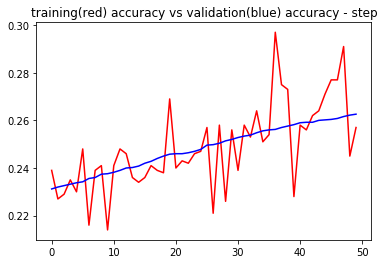

In [55]:
plt.plot(train_accs, 'r-')
plt.plot(val_accs, 'b-')
plt.title("training(red) accuracy vs validation(blue) accuracy - step")
plt.show()

**Q: Approximately what were the top train and validation accuracies reached during these 5,000 steps? What could be the problem here?**

A: The top for training accuracy was approximately 29.5%, while for validation accuracy 26%. When training accuracy was at the peak, validation accuracy was much lower. This indicates the model was overfitting to the training data at that moment.

     0  0.22  0.22
   100  0.50  0.47
   200  0.58  0.58
   300  0.60  0.61
   400  0.63  0.64
   500  0.64  0.66
   600  0.65  0.67
   700  0.66  0.67
   800  0.67  0.69
   900  0.65  0.67
  1000  0.74  0.71
  1100  0.71  0.72
  1200  0.73  0.72
  1300  0.70  0.71
  1400  0.74  0.72
  1500  0.75  0.73
  1600  0.73  0.72
  1700  0.73  0.72
  1800  0.70  0.71
  1900  0.74  0.72
  2000  0.76  0.73
  2100  0.75  0.72
  2200  0.75  0.74
  2300  0.73  0.74
  2400  0.75  0.74
  2500  0.77  0.74
  2600  0.73  0.74
  2700  0.72  0.74
  2800  0.72  0.73
  2900  0.76  0.74
  3000  0.73  0.74
  3100  0.75  0.74
  3200  0.74  0.74
  3300  0.74  0.72
  3400  0.76  0.74
  3500  0.74  0.75
  3600  0.75  0.74
  3700  0.72  0.75
  3800  0.74  0.74
  3900  0.77  0.75
  4000  0.76  0.74
  4100  0.76  0.75
  4200  0.75  0.75
  4300  0.75  0.74
  4400  0.76  0.75
  4500  0.71  0.75
  4600  0.75  0.73
  4700  0.73  0.74
  4800  0.73  0.73
  4900  0.73  0.74


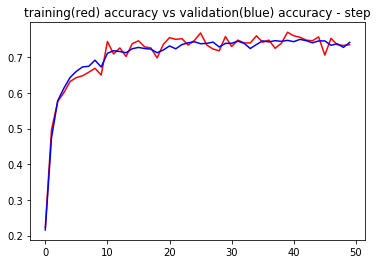

In [82]:
# Optimization on current model to reach an accuracy of 60% above

model = LinearModel() # re-create a model to start from begninning
optimizer = torch.optim.Adadelta(model.parameters(), lr=0.1)

train_accs, val_accs = [], []
for i in range(NUM_OPT_STEPS):
    train(1) # use SGD, 1 example
    if i % 100 == 0:
        train_accs.append(approx_train_accuracy())
        val_accs.append(val_accuracy())
        print("%6d %5.2f %5.2f" % (i, train_accs[-1], val_accs[-1]))
plt.plot(train_accs, 'r-')
plt.plot(val_accs, 'b-')
plt.title("training(red) accuracy vs validation(blue) accuracy - step")
plt.show()

**Q: What was the final optimizer, learning rate pair that led to reasonable validation accuracy? What was the best validation accuracy that you achieved?**

A: After testing all the optimizers in torch.optim with the same lr of 0.1, Adadelta gave the best validataion accuracy of 0.75.

|Optimizer      | Validation accu|
| ------------- |:--------------:|
| Adadelta      | 0.74-0.75      |
| Adagrad       | 0.72-0.73      |
| Adamax        | 0.69-0.71      |
| ASGD          | 0.67-0.69      |
| LBFGS         | -              |
| RMSprop       | 0.70-0.71      |
| Rprop         | 0.51           |
| SGD           | 0.68-0.69      |